Author: Jake Singleton

# Goal:
Predict each player’s strikeout percentage in the second half of the 2017 season given his pitching statistics in the first half of 2017.

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## We begin with Exploratory Data Analysis

In [2]:
dat = pd.read_csv('./strikeouts.csv')
dat.head()

,Name,Team,fangraphs_id,G,IP,ERA,FIP,xFIP,AVG,K%,BB%,Swing%,Contact%,GB%,LD%,FB%,2ndHalfK%,2ndHalfIP
0,Clayton Kershaw,Dodgers,2036,19,132.1,2.18,3.02,2.76,0.194,0.314,0.044,0.508,0.731,0.453,0.197,0.350,0.249,42.2
1,Max Scherzer,Nationals,3137,18,128.1,2.10,2.62,3.08,0.162,0.355,0.055,0.519,0.692,0.387,0.146,0.467,0.324,72.1
2,Chris Sale,Red Sox,10603,18,127.2,2.75,2.10,2.67,0.198,0.359,0.044,0.513,0.684,0.363,0.218,0.419,0.366,86.2
3,Chris Archer,Rays,6345,19,123.0,3.95,3.17,3.44,0.245,0.285,0.074,0.469,0.719,0.422,0.224,0.354,0.303,78.0
4,Ivan Nova,Pirates,1994,18,120.2,3.21,4.14,4.17,0.252,0.139,0.031,0.495,0.849,0.479,0.228,0.293,0.212,66.1


In [3]:
dat.describe()

,fangraphs_id,G,IP,ERA,FIP,xFIP,AVG,K%,BB%,Swing%,Contact%,GB%,LD%,FB%,2ndHalfK%,2ndHalfIP
count,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000
mean,9189.635135,24.429054,60.499662,3.946791,4.099831,4.180203,0.239108,0.229264,0.083554,0.467956,0.768922,0.448557,0.198003,0.353463,0.225490,45.620946
std,4537.266935,11.280779,29.000082,1.378712,1.116321,0.828652,0.041719,0.064831,0.025188,0.034104,0.054050,0.081610,0.033911,0.081118,0.066184,24.837653
min,18.000000,6.000000,30.000000,0.760000,0.790000,1.240000,0.110000,0.094000,0.015000,0.348000,0.590000,0.267000,0.081000,0.111000,0.060000,10.000000
25%,5223.250000,16.000000,35.200000,2.937500,3.407500,3.690000,0.209750,0.183750,0.066000,0.445000,0.732750,0.394000,0.176000,0.302750,0.182750,25.200000
50%,9445.000000,18.500000,46.050000,3.825000,4.065000,4.225000,0.242500,0.217000,0.082000,0.469000,0.772500,0.445500,0.198500,0.354000,0.217000,35.150000
75%,13134.750000,36.000000,85.400000,4.792500,4.812500,4.742500,0.264000,0.271250,0.100000,0.490000,0.810000,0.493000,0.220000,0.410000,0.266250,68.125000
max,18815.000000,44.000000,132.100000,8.140000,7.830000,6.110000,0.359000,0.508000,0.160000,0.576000,0.892000,0.756000,0.298000,0.580000,0.483000,110.100000


In [4]:
dat.shape

(296, 18)

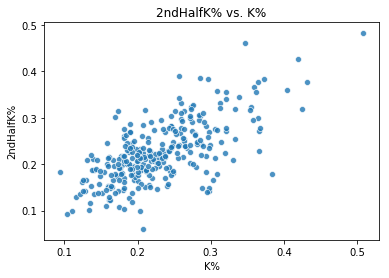

In [5]:
# We expect a positive linear relationship here, which we see.
sns.scatterplot(x='K%', y='2ndHalfK%', data=dat, alpha=0.8)
plt.title('2ndHalfK% vs. K%');

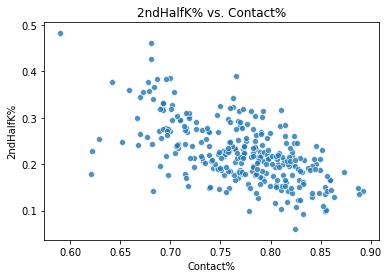

In [6]:
# We expect a negative linear relationship here, which we see.
sns.scatterplot(x='Contact%', y='2ndHalfK%', data=dat, alpha=0.8)
plt.title('2ndHalfK% vs. Contact%');

## Modeling
The data looks good from initial inspection, so we can begin the featurization and modeling process.

We will use a linear model here since from our initial inspection above, a linear model might do a good job. I will try both simple linear regression and Lasso regularization. If linear regression gives good results, we will then go through cross validation for feature selection. If Lasso is the best choice, it will have already chosen our features for us.

In [7]:
# We drop categorical data
features = dat.drop(['Name', 'Team', 'fangraphs_id'], axis = 1)
features.shape

(296, 15)

In [8]:
# Labels are the values we want to predict
labels = pd.Series(features['2ndHalfK%'])

features = features.drop('2ndHalfK%', axis = 1)

In [9]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25,
                                                                           random_state = 42)

In [10]:
import sklearn.linear_model as lm

# Fit the classifiers
linear_model = lm.LinearRegression()
linear_model.fit(train_features, train_labels)

# Seeing what Lasso gives for various values of lambda. I am interested in Lasso because it seems many of the
# features may not be useful, making me think Lasso could eliminate some of these.
for param in [1.0, 0.1, 0.01, 0.001, 0.0001]:
    model = lm.Lasso(alpha=param, max_iter=10e5)
    model.fit(train_features, train_labels)
    print('Training score:', model.score(train_features, train_labels))
    print('Testing score:', model.score(test_features, test_labels))
    print('Coefficients used:', model.coef_)
    
print(linear_model.score(train_features, train_labels))
print(linear_model.score(test_features, test_labels))

Training score: 0.0
Testing score: -0.024469418169262402
Coefficients used: [ 0. -0. -0. -0. -0. -0.  0.  0.  0. -0. -0.  0.  0. -0.]
Training score: 0.060744418478115514
Testing score: 0.019754298162873662
Coefficients used: [ 0.00082673 -0.         -0.         -0.         -0.         -0.
  0.          0.          0.         -0.         -0.          0.
  0.          0.        ]
Training score: 0.21912615362307986
Testing score: 0.2121656950439802
Coefficients used: [ 1.19905660e-03 -1.48946015e-05 -7.12528994e-04 -6.88750419e-03
 -9.72038031e-03 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.91793448e-04]
Training score: 0.3335375261108782
Testing score: 0.3641260545497302
Coefficients used: [ 0.00081105 -0.00012732 -0.00301904 -0.0021858  -0.03142606 -0.
  0.          0.         -0.         -0.         -0.11170019  0.
  0.          0.00031106]
Training score: 0.4813848829948776
Testing score: 0.5117

Lasso doesn't seem to be beneficial here. Most of these values of lambda create so much sparsity it's not worth using, so we will use multiple linear regression.

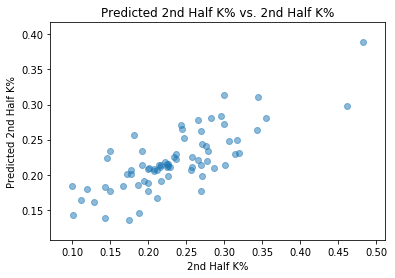

In [11]:
# Make predictions
pred_labels = linear_model.predict(test_features)

plt.scatter(test_labels, pred_labels, alpha=0.5)
plt.xlabel('2nd Half K%')
plt.ylabel('Predicted 2nd Half K%')
plt.title('Predicted 2nd Half K% vs. 2nd Half K%');

We use the root mean squared error (RMSE) to assess error:

$$
\textbf{RMSE} = \sqrt{\frac{1}{n}\sum_{i=1}^n \left( y_i - \hat{y}_i \right)^2 }
$$

In [12]:
def rmse(actual_y, predicted_y):
    return np.sqrt(np.mean((actual_y - predicted_y)**2))

In [13]:
train_error = rmse(train_labels, linear_model.predict(train_features))
test_error = rmse(test_labels, linear_model.predict(test_features))

print('Training RMSE:', train_error)
print('Test RMSE:', test_error)

Training RMSE: 0.045304244517098684
Test RMSE: 0.04800786449147468


Test RMSE > Training RMSE makes sense.

## Cross Validation

Since we decided to use linear regression, we go through cross validation to select our features.

In [14]:
from sklearn.model_selection import KFold

def compute_CV_error(model, train_features, train_labels):
    kf = KFold(n_splits=5)
    validation_errors = []
    
    for train_idx, valid_idx in kf.split(train_features):
        # split the data
        split_train_features, split_train_valid = train_features.iloc[train_idx, :], train_features.iloc[valid_idx, :]
        split_train_labels, split_labels_valid = train_labels.iloc[train_idx], train_labels.iloc[valid_idx]

        # Fit the model on the training split
        linear_model.fit(split_train_features, split_train_labels)
        
        # Compute the RMSE on the validation split
        error = rmse(split_labels_valid, linear_model.predict(split_train_valid))
        
        validation_errors.append(error)
        
    return np.mean(validation_errors)

In [15]:
feature_sets = [
    ['K%', 'Swing%', 'Contact%'], 
    ['Contact%', 'GB%', 'LD%'], 
    ['K%', 'BB%', 'xFIP'], 
    ['Swing%', 'LD%', 'FB%'],
    ['K%', 'Contact%', 'LD%']
]

errors = []
for feat in feature_sets:
    print('Trying features:', feat)
    model = lm.LinearRegression()
    error = compute_CV_error(model, train_features[feat], train_labels) # compute the cross validation error
    print('\tRMSE:', error)
    errors.append(error)

best_err_idx = errors.index(min(errors))
best_err = min(errors)
best_feature_set = feature_sets[best_err_idx]

for i in range(4):
    print('{}, error: {}'.format(feature_sets[i], errors[i]))

best_feature_set, best_err

Trying features: ['K%', 'Swing%', 'Contact%']
	RMSE: 0.047784495623652994
Trying features: ['Contact%', 'GB%', 'LD%']
	RMSE: 0.05140452951886228
Trying features: ['K%', 'BB%', 'xFIP']
	RMSE: 0.04834648759585408
Trying features: ['Swing%', 'LD%', 'FB%']
	RMSE: 0.0643545386431525
Trying features: ['K%', 'Contact%', 'LD%']
	RMSE: 0.04726580571370006
['K%', 'Swing%', 'Contact%'], error: 0.047784495623652994
['Contact%', 'GB%', 'LD%'], error: 0.05140452951886228
['K%', 'BB%', 'xFIP'], error: 0.04834648759585408
['Swing%', 'LD%', 'FB%'], error: 0.0643545386431525


(['K%', 'Contact%', 'LD%'], 0.04726580571370006)

**Note:** I know this is not the most efficient or necessarily optimal way to select your model's features. I did it this way because 1) it helps me understand what is going on, and 2) this is how I first learned cross-validation. I know there are better ways to do this using functions such as `cross_val_predict` and `SelectKBest`, but since I am relatively new to modeling, I used the approach above. (The skeleton for this algorithm was provided in one of my classes this semester. I filled in the key steps).

## Using `SelectKBest`

In [16]:
from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(f_regression, k=3)
train_features_new = selector.fit_transform(train_features, train_labels)

In [17]:
train_features_new.shape

(222, 3)

In [18]:
mask = selector.get_support()
KBest_features = []

for bool, feature in zip(mask, list(train_features.columns)):
    if bool:
        KBest_features.append(feature)

KBest_features

['AVG', 'K%', 'Contact%']

In [19]:
linear_model_with_KBest = lm.LinearRegression()
linear_model_with_KBest.fit(train_features[KBest_features], train_labels)

train_predictions_with_KBest = linear_model_with_KBest.predict(train_features[KBest_features])
test_predictions_with_KBest = linear_model_with_KBest.predict(test_features[KBest_features])

train_rmse_with_KBest = rmse(train_labels, train_predictions_with_KBest)
test_rmse_with_KBest = rmse(test_labels, test_predictions_with_KBest)

print('Train RMSE w/ KBest', train_rmse_with_KBest)
print('Test RMSE w/ KBest', test_rmse_with_KBest)

Train RMSE w/ KBest 0.04745923487639997
Test RMSE w/ KBest 0.05172411531350999


In [20]:
model_KBest = linear_model_with_KBest.fit(test_features[KBest_features], test_labels)

print(model_KBest.coef_)
print(model_KBest.intercept_)

[-0.15608042  0.66803474 -0.18011837]
0.2591241714165613


Our KBest model is:

$\hat{y} \approx -0.156$**AVG**$ + 0.668$**K%**$ - 0.180$**Contact%**$ + 0.259$, where $\hat{y}$ is predicted **2ndHalfK%**.

In [21]:
# Adding a column: 
dat2 = dat
dat2['predicted2ndHalfK%'] = round(-0.156*dat['AVG'] + 0.668*dat['K%'] - 0.180*dat['Contact%'] + 0.259, 3)
new_order = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,18,16,17]
dat2 = dat2[dat.columns[new_order]]
dat2.head(10)

,Name,Team,fangraphs_id,G,IP,ERA,FIP,xFIP,AVG,K%,BB%,Swing%,Contact%,GB%,LD%,FB%,predicted2ndHalfK%,2ndHalfK%,2ndHalfIP
0,Clayton Kershaw,Dodgers,2036,19,132.1,2.18,3.02,2.76,0.194,0.314,0.044,0.508,0.731,0.453,0.197,0.350,0.307,0.249,42.2
1,Max Scherzer,Nationals,3137,18,128.1,2.10,2.62,3.08,0.162,0.355,0.055,0.519,0.692,0.387,0.146,0.467,0.346,0.324,72.1
2,Chris Sale,Red Sox,10603,18,127.2,2.75,2.10,2.67,0.198,0.359,0.044,0.513,0.684,0.363,0.218,0.419,0.345,0.366,86.2
3,Chris Archer,Rays,6345,19,123.0,3.95,3.17,3.44,0.245,0.285,0.074,0.469,0.719,0.422,0.224,0.354,0.282,0.303,78.0
4,Ivan Nova,Pirates,1994,18,120.2,3.21,4.14,4.17,0.252,0.139,0.031,0.495,0.849,0.479,0.228,0.293,0.160,0.212,66.1
5,Ervin Santana,Twins,3200,18,120.1,2.99,4.69,4.80,0.204,0.188,0.083,0.481,0.807,0.443,0.152,0.405,0.208,0.201,91.0
6,Rick Porcello,Red Sox,2717,19,119.1,4.75,4.08,4.35,0.295,0.208,0.046,0.507,0.812,0.378,0.215,0.407,0.206,0.200,84.0
7,Yu Darvish,Rangers,13074,19,118.2,3.49,3.86,3.92,0.213,0.259,0.085,0.462,0.758,0.403,0.229,0.368,0.262,0.297,68.0
8,Jeff Samardzija,Giants,3254,18,118.0,4.58,3.45,3.09,0.261,0.262,0.029,0.494,0.787,0.432,0.247,0.321,0.252,0.216,89.2
9,Zack Greinke,Diamondbacks,1943,18,116.1,2.86,3.17,3.13,0.214,0.287,0.050,0.462,0.708,0.466,0.174,0.359,0.290,0.244,86.0


## Using `cross_val_predict`

In [22]:
from sklearn.model_selection import cross_validate

lm_with_cv = lm.LinearRegression()
y_pred_with_cv = cross_validate(lm_with_cv, 
                                train_features, train_labels, 
                                cv=5, 
                                scoring=('r2', 'neg_mean_squared_error'), 
                                return_train_score=True)
print(np.sqrt(abs(np.array(y_pred_with_cv['test_neg_mean_squared_error']))))
print(y_pred_with_cv['train_r2'])

[0.04057104 0.05333414 0.05361779 0.04789152 0.05292075]
[0.49109731 0.52544615 0.53837736 0.45096316 0.55121623]


## Using best feature set to define our final model + Calculating error

In [23]:
# Fitting my model using the best features
linear_model.fit(train_features[best_feature_set], train_labels)

train_predictions = linear_model.predict(train_features[best_feature_set])
test_predictions = linear_model.predict(test_features[best_feature_set])

# Predict points from our test set and calculate the mse
train_rmse = rmse(train_labels, train_predictions)
test_rmse = rmse(test_labels, test_predictions)

print('Train RMSE', train_rmse)
print('KFold Validation RMSE', best_err)
print('Test RMSE', test_rmse)

Train RMSE 0.04700995662907964
KFold Validation RMSE 0.04726580571370006
Test RMSE 0.05069458162196552


Our predictions are good!

# Residual Plot

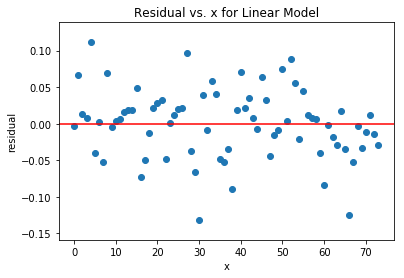

In [24]:
# Exam residuals for each record from the test set.
model = model.fit(test_features[best_feature_set], test_labels)

plt.scatter(np.arange(len(test_features)), test_labels - model.predict(test_features[best_feature_set]))
plt.xlabel('x')
plt.ylabel('residual')
plt.title('Residual vs. x for Linear Model')
plt.axhline(y = 0, color='r');

Points are randomly scattered around y = 0, meaning a linear regression model is a good choice for the data we have.

## Our Final Model + Comments

In [25]:
print(model.coef_)
print(model.intercept_)

[ 0.65867993 -0.30468051  0.37600374]
0.2454026729111662


Our final model is:

$\hat{y} \approx 0.659$**K%**$ - 0.305$**Contact%**$ + 0.376$**LD%**$ + 0.245$, where $\hat{y}$ is predicted **2ndHalfK%**. 

We note that the negative coefficient here corresponds to Contact%, which makes sense, since an increase in Contact% means a decrease in strikeout percentage. It is not surprising K% is an important predictor, but LD% is a bit surprising. This would be worth investigating further since the less hard a pitcher is getting hit, the better he is. Unfortunately I don't really have time to look into this, but I suspect that our choice of feature_sets to test for cross validation might not be optimal. As a possible solution, when we cross validate, we could define feature_sets to include all ${13\choose 3}$ possible 3-feature subsets of our 13 features. Overall though, our model is useful, which is what we want!

In [26]:
dat.head(3)

,Name,Team,fangraphs_id,G,IP,ERA,FIP,xFIP,AVG,K%,BB%,Swing%,Contact%,GB%,LD%,FB%,2ndHalfK%,2ndHalfIP,predicted2ndHalfK%
0,Clayton Kershaw,Dodgers,2036,19,132.1,2.18,3.02,2.76,0.194,0.314,0.044,0.508,0.731,0.453,0.197,0.350,0.249,42.2,0.307
1,Max Scherzer,Nationals,3137,18,128.1,2.10,2.62,3.08,0.162,0.355,0.055,0.519,0.692,0.387,0.146,0.467,0.324,72.1,0.346
2,Chris Sale,Red Sox,10603,18,127.2,2.75,2.10,2.67,0.198,0.359,0.044,0.513,0.684,0.363,0.218,0.419,0.366,86.2,0.345


If we look back at our original data for fun, we might look at our prediction for the first 3 pitchers (who all are traditionally huge strikeout guys):

In [27]:
# We predict Clayton Kershaw's 2017 2nd Half K% to be:
val = 0.659*.314 - 0.305*.731 + 0.376*0.197 + 0.245
print('KERSHAW: Predicted', round(val, 3), 'Actual', 0.249)

# We predict Max Scherzer's 2017 2nd Half K% to be:
val2 = 0.659*0.355 - 0.305*0.692 + 0.376*.146 + 0.245
print('SCHERZER: Predicted', round(val2, 3), 'Actual', 0.324)

# We predict Chris Sale's 2017 2nd Half K% to be:
val3 = 0.659*.359 - 0.305*.684 + 0.376*.218 + 0.245
print('SALE: Predicted', round(val3, 3), 'Actual', 0.366)

KERSHAW: Predicted 0.303 Actual 0.249
SCHERZER: Predicted 0.323 Actual 0.324
SALE: Predicted 0.355 Actual 0.366


Not bad! We know that in 2017, Kershaw got hurt in late July and missed all of August due to a back issue, which has hurt his strikeout numbers significantly. We can also use the '2ndHalfIP' column to check for things like this. This explains why our prediction for him is off. For Scherzer and Sale, our model does a good job.

In [28]:
# We can also add a new column to see predictions for everyone in our data set:
dat['predicted2ndHalfK%'] = round(0.659*dat['K%'] - 0.305*dat['Contact%'] + 0.376*dat['LD%'] + 0.245, 3)
new_order = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,18,16,17]
dat = dat[dat.columns[new_order]]
dat.tail(5)

,Name,Team,fangraphs_id,G,IP,ERA,FIP,xFIP,AVG,K%,BB%,Swing%,Contact%,GB%,LD%,FB%,predicted2ndHalfK%,2ndHalfK%,2ndHalfIP
291,Daniel Gossett,Athletics,16164,6,30.1,6.23,5.76,4.15,0.292,0.148,0.037,0.464,0.829,0.477,0.239,0.284,0.180,0.186,61.0
292,Wade Davis,Cubs,7441,31,30.0,1.80,2.02,2.90,0.168,0.358,0.100,0.472,0.702,0.397,0.254,0.349,0.362,0.295,28.2
293,Andrew Chafin,Diamondbacks,12988,40,30.0,1.80,1.92,2.20,0.198,0.331,0.083,0.425,0.742,0.614,0.214,0.171,0.317,0.210,21.1
294,Jarlin Garcia,Marlins,18282,39,30.0,3.60,4.16,4.74,0.182,0.217,0.067,0.469,0.740,0.349,0.181,0.470,0.230,0.152,23.1
295,Jose Alvarez,Angels,5358,40,30.0,5.40,4.56,4.27,0.261,0.216,0.048,0.503,0.797,0.352,0.220,0.429,0.227,0.231,18.2


In [29]:
dat2.tail(5)

,Name,Team,fangraphs_id,G,IP,ERA,FIP,xFIP,AVG,K%,BB%,Swing%,Contact%,GB%,LD%,FB%,predicted2ndHalfK%,2ndHalfK%,2ndHalfIP
291,Daniel Gossett,Athletics,16164,6,30.1,6.23,5.76,4.15,0.292,0.148,0.037,0.464,0.829,0.477,0.239,0.284,0.163,0.186,61.0
292,Wade Davis,Cubs,7441,31,30.0,1.80,2.02,2.90,0.168,0.358,0.100,0.472,0.702,0.397,0.254,0.349,0.346,0.295,28.2
293,Andrew Chafin,Diamondbacks,12988,40,30.0,1.80,1.92,2.20,0.198,0.331,0.083,0.425,0.742,0.614,0.214,0.171,0.316,0.210,21.1
294,Jarlin Garcia,Marlins,18282,39,30.0,3.60,4.16,4.74,0.182,0.217,0.067,0.469,0.740,0.349,0.181,0.470,0.242,0.152,23.1
295,Jose Alvarez,Angels,5358,40,30.0,5.40,4.56,4.27,0.261,0.216,0.048,0.503,0.797,0.352,0.220,0.429,0.219,0.231,18.2


In [30]:
print(sum(abs(dat['predicted2ndHalfK%']-dat['2ndHalfK%'])))
print(sum(abs(dat2['predicted2ndHalfK%']-dat2['2ndHalfK%'])))

11.368999999999994
11.651
